<a href="https://www.kaggle.com/code/gunrsbelti/ml-2-homework-ga22008?scriptVersionId=228924832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Author: Gunārs Ābeltiņš, ga22008

## Library imports

In [1]:
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset initialization

In [2]:
class HandDataset(Dataset):
    """
    Custom dataset class for loading hand gesture images and their labels.
    """
    
    def __init__(self, data_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),  
        transforms.ToTensor()           
    ])):
        """
        Initializes the dataset.

        Args:
            data_dir (str): Path to the directory containing image files.
            transform (callable, optional): A function/transform to apply to each image.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of image files in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Returns the image and its label at the specified index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: (image, label) where `image` is a tensor of shape (C, H, W) and `label` is the integer class label.
        """
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        image = self.transform(image)
        
        # Extract label from the filename (assuming format like 'label_imageName.jpg')
        label = int(img_name.split('_')[0])
        
        return image, label


train_dir = '../input/dotu-kopa-rokas/train'
test_dir = '../input/dotu-kopa-rokas/test'

train_dataset = HandDataset(train_dir)
print(f"Initialized training dataset with [{len(train_dataset)}] samples")

test_dataset = HandDataset(test_dir)
print(f"Initialized testing dataset with [{len(test_dataset)}] samples")

Initialized training dataset with [1172] samples
Initialized testing dataset with [100] samples


## Statistics about data

In [3]:
def get_labels(dataset):
    """
    Extracts the labels from the dataset based on the filenames and counts the occurrences of each label.

    Args:
        dataset (HandDataset): The dataset containing image files with labels embedded in filenames.

    Returns:
        Counter: A Counter object with labels as keys and their respective counts as values.
    """
    # Access files directly as it's faster
    labels = [int(file.split('_')[0]) for file in dataset.image_files]
    
    # Count occurrences of each label
    class_counts = Counter(labels)
    
    return class_counts

train_labels = get_labels(train_dataset)
test_labels = get_labels(test_dataset)

print("Training dataset:")
for k, v in sorted(train_labels.items()):
    print(f"Class [{k}]: [{v}] samples")

print("\nTest dataset:")
for k, v in sorted(test_labels.items()):
    print(f"Class [{k}]: [{v}] samples")

Training dataset:
Class [1]: [238] samples
Class [2]: [234] samples
Class [3]: [242] samples
Class [4]: [232] samples
Class [5]: [226] samples

Test dataset:
Class [1]: [20] samples
Class [2]: [20] samples
Class [3]: [20] samples
Class [4]: [20] samples
Class [5]: [20] samples


## Dataset visualization

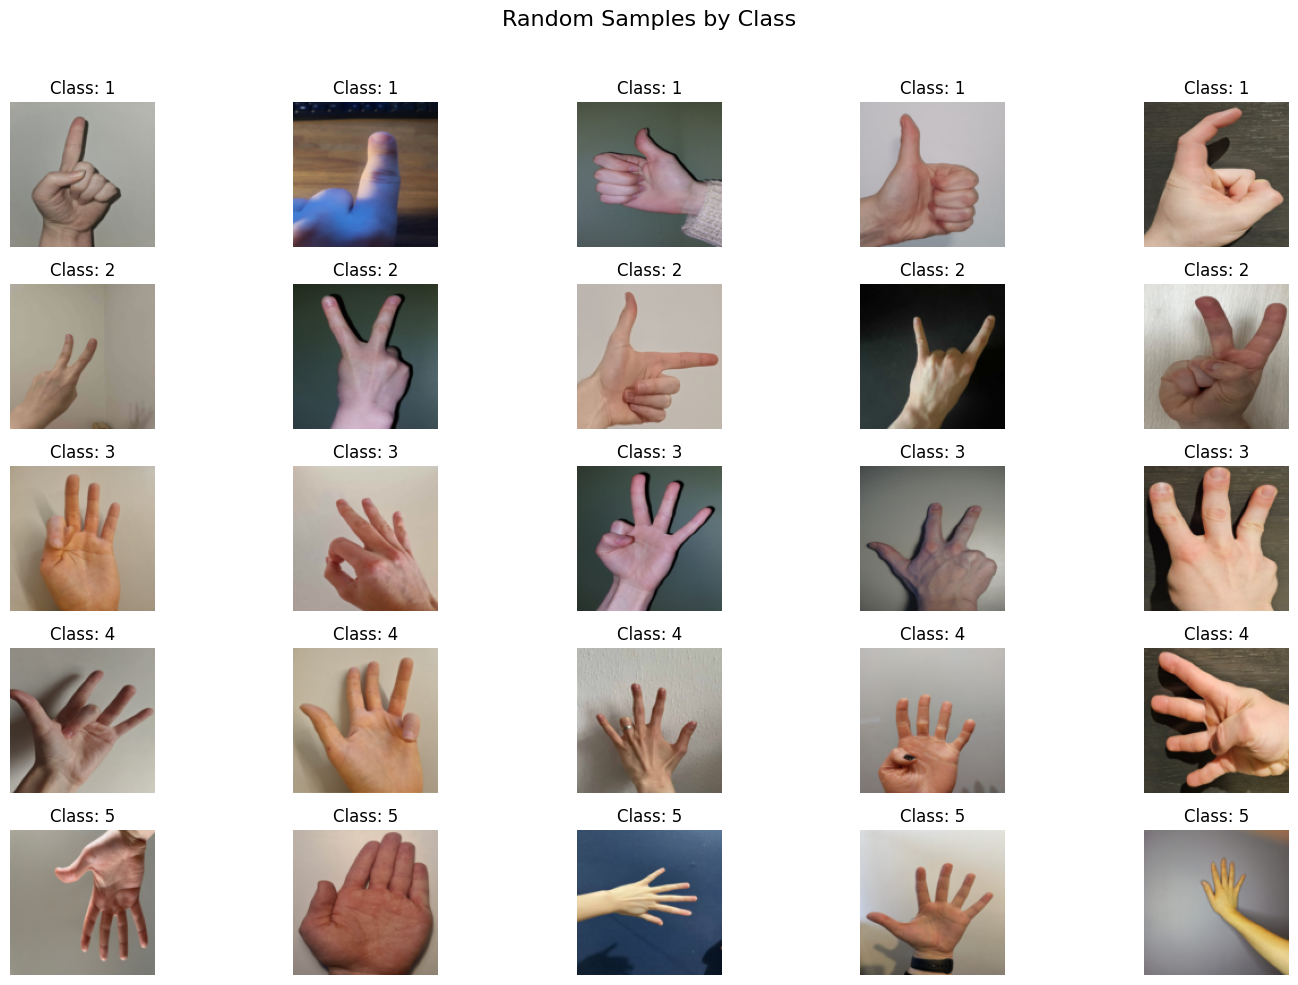

In [4]:
def visualize_dataset(dataset, num_samples=5, class_range=(1, 5), figsize=(15, 10)):
    """
    Displays random sample images from each class in the given dataset.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset containing images and labels.
        num_samples (int): The number of sample images to display per class.
        class_range (tuple): The range of class labels (inclusive) to visualize.
        figsize (tuple): Figure size as (width, height) in inches.
    """
    
    # Create a DataLoader for efficient dataset iteration
    batch_size = 1
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize dictionary to store images by class
    min_class, max_class = class_range
    classes_to_visualize = range(min_class, max_class + 1)
    class_to_images = {label: [] for label in classes_to_visualize}
    
    # Collect images for each class
    for image_batch, label_batch in data_loader:
        class_label = label_batch.item()
        
        # Skip classes outside our range
        if class_label not in class_to_images:
            continue
            
        # Add image to the appropriate class list if needed
        if len(class_to_images[class_label]) < num_samples:
            class_to_images[class_label].append(image_batch.squeeze(0))
            
        # Break loop if we've collected enough samples for each class
        if all(len(images) >= num_samples for images in class_to_images.values()):
            break
    
    # Create subplot grid for visualization
    num_classes = len(class_to_images)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=figsize)
    fig.suptitle('Random Samples by Class', fontsize=16)
    
    # Display images for each class
    for row_idx, (class_label, images) in enumerate(sorted(class_to_images.items())):
        for col_idx, img in enumerate(images):
            # Handle both single-row and multi-row subplots
            if num_classes == 1:
                ax = axes[col_idx]
            else:
                ax = axes[row_idx, col_idx]
                
            # Convert tensor from channel-first (C,H,W) to channel-last (H,W,C) for display
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(f"Class: {class_label}")
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout with space for title
    plt.show()

visualize_dataset(train_dataset)

## Placeholder model testing

In [5]:
class PlaceholderModel(nn.Module):
    """
    A placeholder neural network model that generates random probabilities 
    for a given number of output classes.
    """
    
    def __init__(self, out_features=5):
        """
        Initialize the PlaceholderModel.

        Args:
            out_features (int): Number of output classes. Default is 5.
        """
        super().__init__()
        self.out_features = out_features

    def forward(self, x):
        """
        Forward pass: Returns random probabilities for each sample in the batch.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, ...).

        Returns:
            torch.Tensor: Probabilities of shape (batch_size, out_features).
        """
        random_scores = torch.rand(x.size(0), self.out_features)
        probabilities = F.softmax(random_scores, dim=1)
        return probabilities


def test_model(ModelClass, dataset):
    """
    Test the performance of a model on a given dataset.

    Args:
        ModelClass (nn.Module): The model class to be tested.
        dataset (Dataset): The dataset to test the model on.
    """
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    model = ModelClass()  # Instantiate the model
    model.eval()  # Set the model to evaluation mode
    
    correct = 0
    total = 0
    
    predicted_labels = []
    true_labels = []
    
    with torch.no_grad(): 
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
    
            total += labels.size(0)  # Increment total sample count
            correct += (predicted == labels).sum().item()  # Count correct predictions
    
            # Store true and predicted labels for later analysis
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())
    
    # Compute accuracy
    accuracy = correct / total
    print(f'Precision (Test dataset): {accuracy:.2%}')

    return predicted_labels, true_labels

predicted_labels, true_labels = test_model(PlaceholderModel, test_dataset)

Precision (Test dataset): 13.00%


## Model visualization

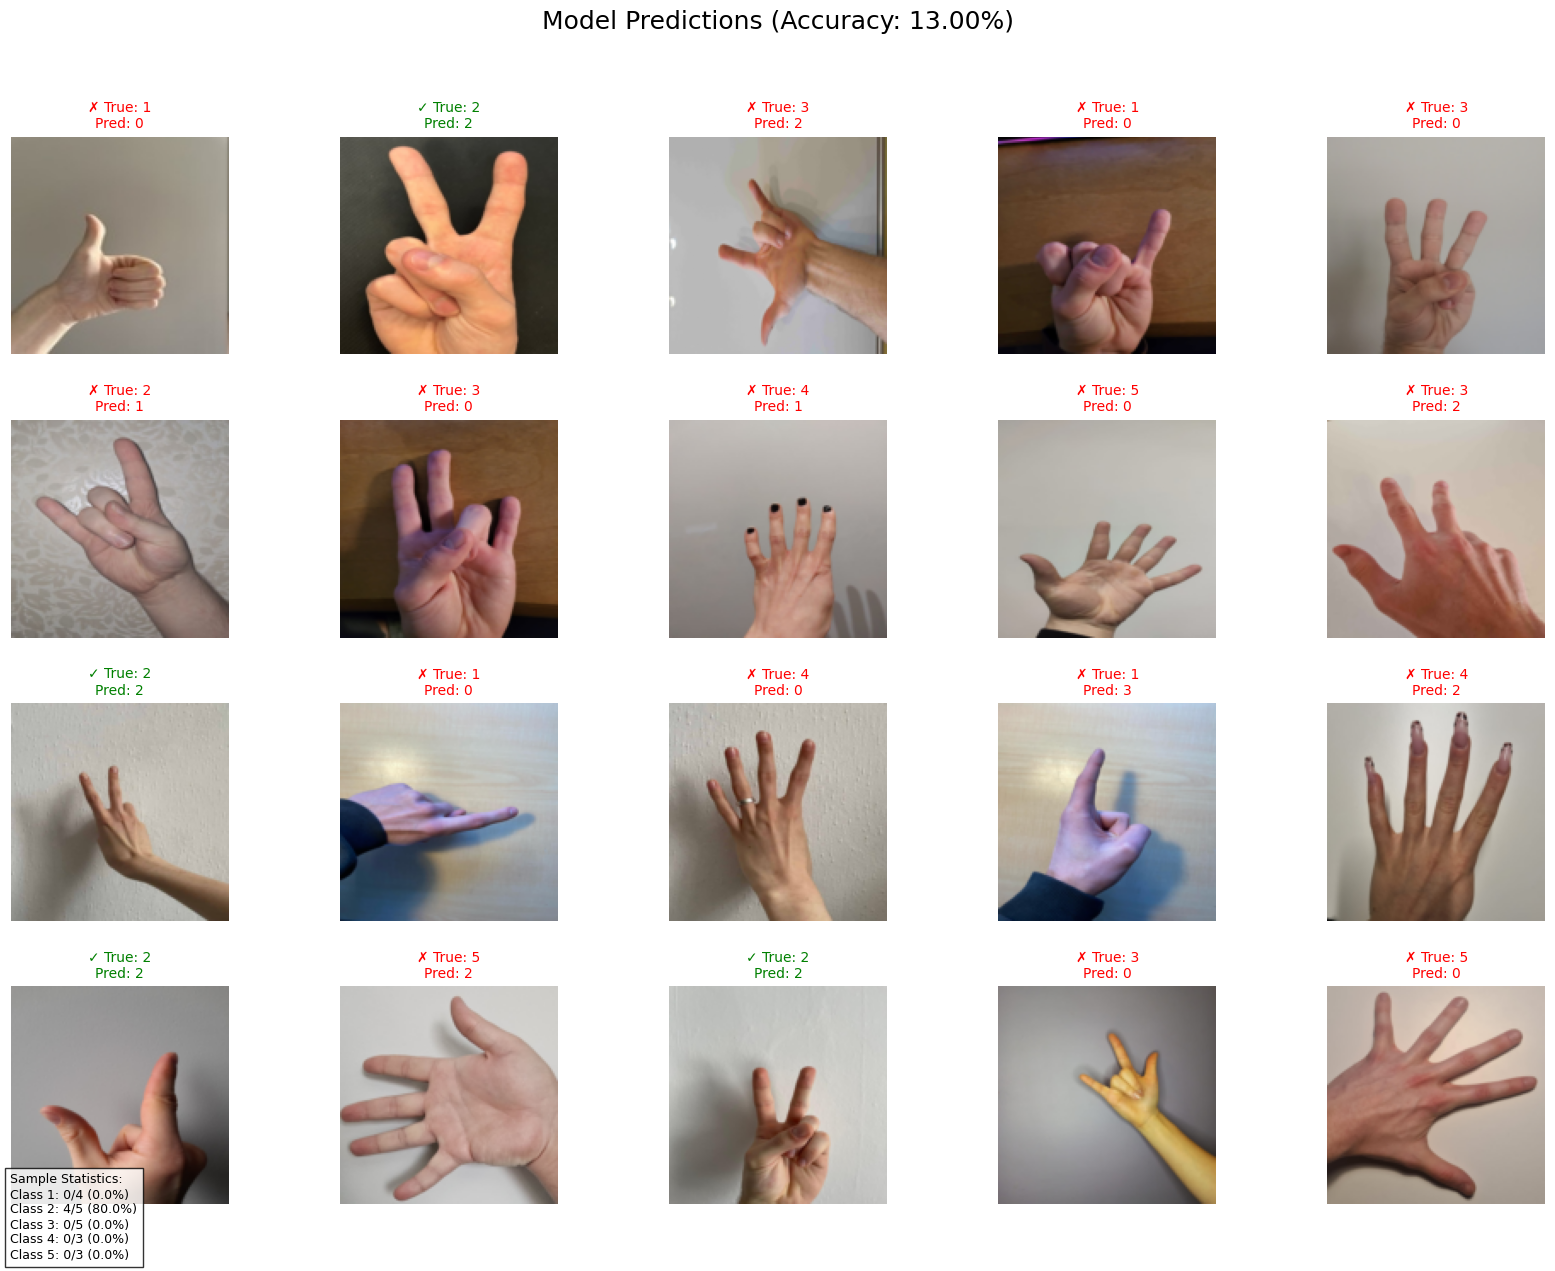

In [6]:
def visualize_model(dataset, true_labels, predicted_labels, num_rows=4, num_cols=5, figsize=(16, 13), random_seed=None):
    """
    Visualizes model predictions by displaying random images from the dataset
    along with their true and predicted labels.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset containing the images and labels.
        true_labels (list or torch.Tensor): The ground truth labels for the dataset.
        predicted_labels (list or torch.Tensor): The predicted labels generated by the model.
        num_rows (int): Number of rows in the display grid.
        num_cols (int): Number of columns in the display grid.
        figsize (tuple): Size of the figure as (width, height) in inches.
        random_seed (int, optional): Seed for random sample selection for reproducibility.
    """
    
    # Convert tensors to lists if needed
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.tolist()
    if isinstance(predicted_labels, torch.Tensor):
        predicted_labels = predicted_labels.tolist()
    
    # Validate inputs
    if len(dataset) != len(true_labels) or len(dataset) != len(predicted_labels):
        raise ValueError(f"Dataset size ({len(dataset)}) must match the number of true labels ({len(true_labels)}) and predicted labels ({len(predicted_labels)})")
    
    # Set random seed for reproducibility if provided
    if random_seed is not None:
        random.seed(random_seed)
    
    # Calculate accuracy to show in the title
    accuracy = sum(t == p for t, p in zip(true_labels, predicted_labels)) / len(true_labels) * 100
    
    # Select random samples to display
    num_samples = min(num_rows * num_cols, len(dataset))
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Create figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    fig.suptitle(f'Model Predictions (Accuracy: {accuracy:.2f}%)', fontsize=18)
    
    # Track class-wise metrics for the sampled images
    sampled_classes = {}
    
    # Display the selected images with their true and predicted labels
    for i, idx in enumerate(indices):
        # Handle both 1D and 2D subplot arrays
        if num_rows == 1:
            ax = axes[i % num_cols] if num_cols > 1 else axes
        elif num_cols == 1:
            ax = axes[i % num_rows] if num_rows > 1 else axes
        else:
            row, col = divmod(i, num_cols)
            ax = axes[row][col]
        
        # Get image and true label
        image, _ = dataset[idx]  # Ignore the dataset label, use our provided labels
        true_class = true_labels[idx]
        pred_class = predicted_labels[idx]
        
        # Update class statistics
        if true_class not in sampled_classes:
            sampled_classes[true_class] = {"total": 0, "correct": 0}
        sampled_classes[true_class]["total"] += 1
        if true_class == pred_class:
            sampled_classes[true_class]["correct"] += 1
        
        # Display the image
        if isinstance(image, torch.Tensor):
            # Handle different tensor formats
            if image.ndim == 3 and image.shape[0] in [1, 3]:  # C,H,W format
                displayed_image = image.permute(1, 2, 0)
            else:
                displayed_image = image
            
            # Convert to numpy for displaying
            displayed_image = displayed_image.numpy()
        else:
            displayed_image = image
            
        # Display the image
        ax.imshow(displayed_image)
        
        # Set title color based on prediction correctness
        is_correct = true_class == pred_class
        title_color = 'green' if is_correct else 'red'
        confidence_indicator = "✓" if is_correct else "✗"
        
        # Set title with prediction information
        ax.set_title(f"{confidence_indicator} True: {true_class}\nPred: {pred_class}", 
                    fontsize=10, color=title_color)
        ax.axis('off')
    
    # If there are unused subplots, hide them
    total_plots = num_rows * num_cols
    for i in range(num_samples, total_plots):
        row, col = divmod(i, num_cols)
        if num_rows > 1 and num_cols > 1:
            axes[row][col].axis('off')
            axes[row][col].set_visible(False)
    
    # Add class-wise accuracy information
    class_info = "\n".join([
        f"Class {cls}: {stats['correct']}/{stats['total']} "
        f"({100 * stats['correct'] / stats['total']:.1f}%)"
        for cls, stats in sorted(sampled_classes.items())
    ])
    
    plt.figtext(0.02, 0.02, f"Sample Statistics:\n{class_info}", 
                fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for title and stats
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Add more space between subplots
    
visualize_model(test_dataset, true_labels, predicted_labels)

## Error visualization

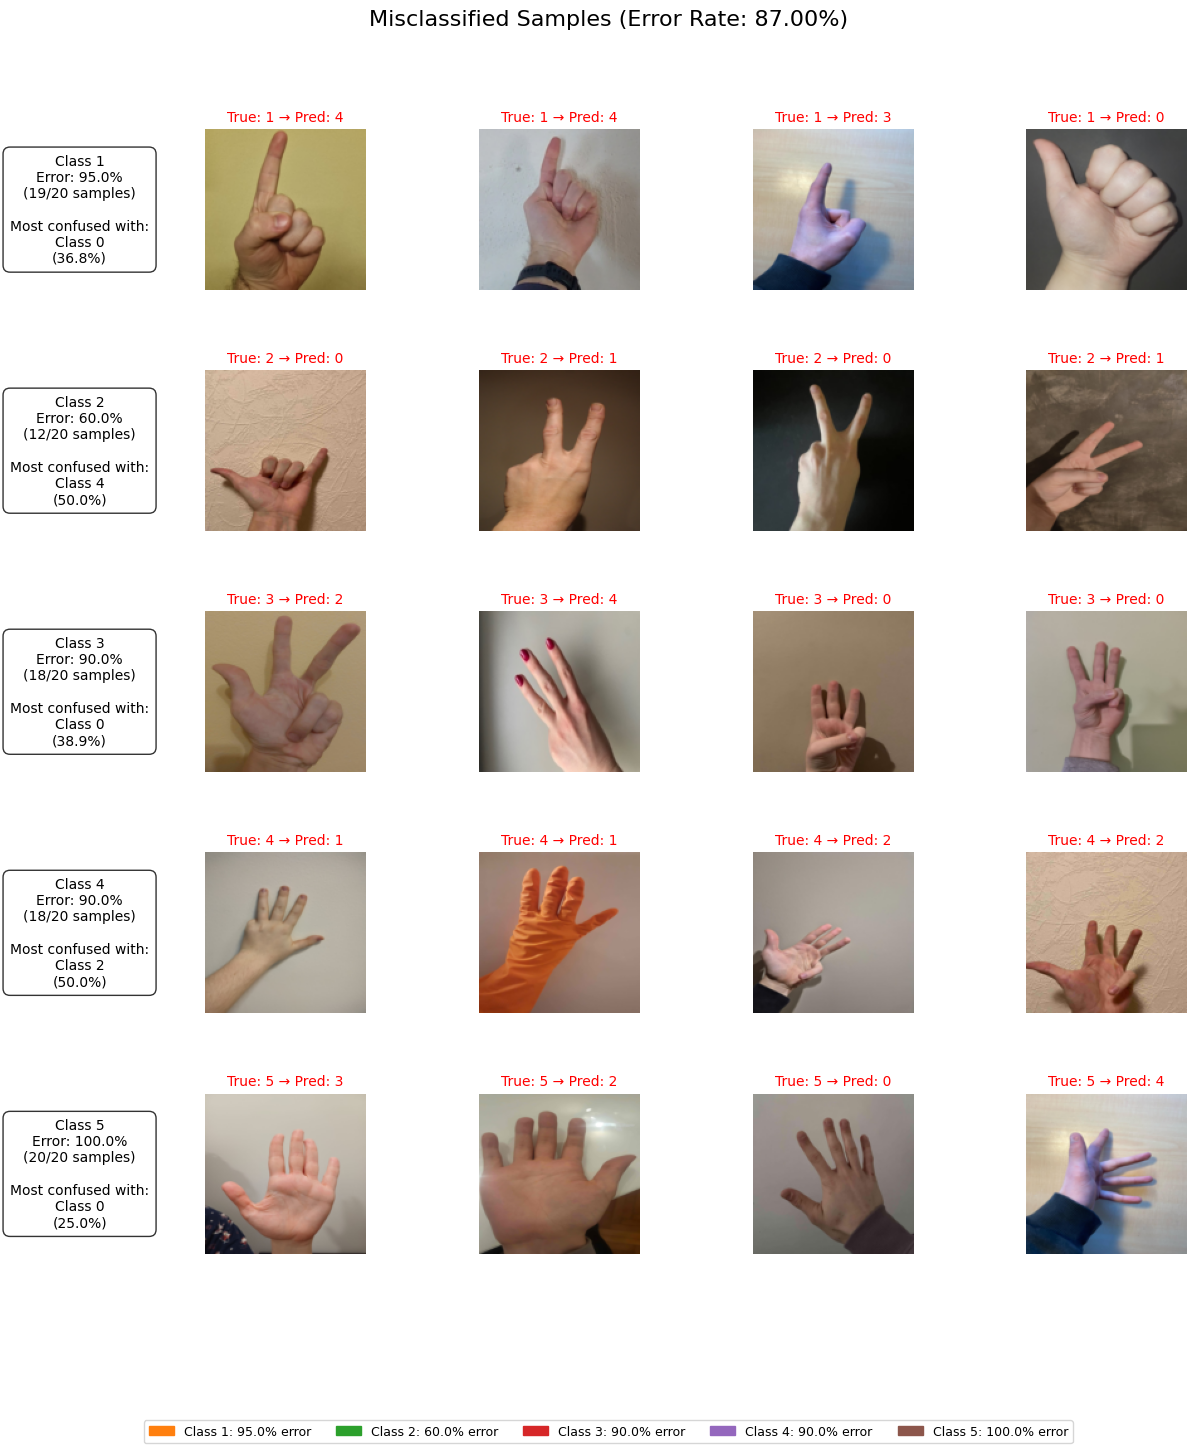

In [7]:
def visualize_errors(dataset, true_labels, predicted_labels, num_samples_per_class=4, 
                              figsize=(15, None), random_seed=None, include_confusion=True):
    """
    Displays misclassified samples from the dataset, grouped by true labels.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset containing images and labels.
        true_labels (list or torch.Tensor): Ground truth labels for the dataset.
        predicted_labels (list or torch.Tensor): Predicted labels generated by the model.
        num_samples_per_class (int): Number of misclassified samples to display per class.
        figsize (tuple): Size of the figure as (width, height) in inches. If height is None,
                         it will be calculated based on the number of classes.
        random_seed (int, optional): Seed for random sample selection for reproducibility.
        include_confusion (bool): Whether to include a small confusion matrix visualization.
    """    
    # Set random seed for reproducibility if provided
    if random_seed is not None:
        random.seed(random_seed)
    
    # Convert tensors to lists if needed
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.tolist()
    if isinstance(predicted_labels, torch.Tensor):
        predicted_labels = predicted_labels.tolist()
    
    # Collect misclassified samples (index, true label, predicted label)
    misclassified = [(i, true, pred) for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) 
                     if true != pred]
    
    # Calculate misclassification rate
    total_samples = len(true_labels)
    num_misclassified = len(misclassified)
    error_rate = num_misclassified / total_samples * 100
    
    # Group misclassified samples by true label
    unique_classes = sorted(set(true_labels))
    misclassified_by_class = {cls: [] for cls in unique_classes}
    for idx, true, pred in misclassified:
        misclassified_by_class[true].append((idx, pred))
    
    # Filter only classes with misclassified samples
    misclassified_by_class = {k: v for k, v in misclassified_by_class.items() if len(v) > 0}
    
    # Calculate class-wise error rates
    class_distribution = Counter(true_labels)
    class_error_rates = {}
    most_common_confusions = {}
    
    for cls in unique_classes:
        if cls in misclassified_by_class:
            misclassified_count = len(misclassified_by_class[cls])
            class_error_rates[cls] = misclassified_count / class_distribution[cls] * 100
            
            # Find most common incorrect predictions for this class
            pred_counter = Counter([pred for _, pred in misclassified_by_class[cls]])
            most_common = pred_counter.most_common(1)
            if most_common:
                most_common_confusions[cls] = (most_common[0][0], most_common[0][1])
        else:
            class_error_rates[cls] = 0.0
    
    # Create a grid for visualization
    num_rows = len(misclassified_by_class)
    if num_rows == 0:
        print("No misclassified samples found!")
        return None
    
    # Auto-calculate figure height if not provided
    if figsize[1] is None:
        figsize = (figsize[0], 3 * num_rows)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'Misclassified Samples (Error Rate: {error_rate:.2f}%)', fontsize=16)
    
    # Properly determine grid dimensions to avoid tight_layout warnings
    if include_confusion:
        # Create a grid with appropriate spacing
        gs = plt.GridSpec(num_rows, num_samples_per_class + 1, figure=fig,
                         width_ratios=[1] + [3] * num_samples_per_class,
                         wspace=0.4, hspace=0.5)
    else:
        gs = plt.GridSpec(num_rows, num_samples_per_class, figure=fig,
                         wspace=0.4, hspace=0.5)
    
    for row, (true_label, samples) in enumerate(sorted(misclassified_by_class.items())):
        # Calculate class-specific error rate
        error_percent = class_error_rates[true_label]
        
        # Add a text label for the row if confusion info is enabled
        if include_confusion:
            ax_info = fig.add_subplot(gs[row, 0])
            ax_info.axis('off')
            
            # Create info text with class error rate
            info_text = (f"Class {true_label}\n"
                        f"Error: {error_percent:.1f}%\n"
                        f"({len(samples)}/{class_distribution[true_label]} samples)")
            
            # Add confusion information if available
            if true_label in most_common_confusions:
                confused_with, count = most_common_confusions[true_label]
                confusion_percent = (count / len(samples)) * 100
                info_text += f"\n\nMost confused with:\nClass {confused_with}\n({confusion_percent:.1f}%)"
            
            ax_info.text(0.5, 0.5, info_text, 
                        horizontalalignment='center', 
                        verticalalignment='center',
                        fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
            
            # Offset for image columns when confusion panel is included
            col_offset = 1
        else:
            col_offset = 0
        
        # Select up to `num_samples_per_class` samples for display
        selected_samples = random.sample(samples, min(num_samples_per_class, len(samples)))
        
        for i, (idx, pred) in enumerate(selected_samples):
            # Get the appropriate subplot
            ax = fig.add_subplot(gs[row, i + col_offset])
            
            # Get and display the image
            image, _ = dataset[idx]
            
            # Handle tensor conversion for display
            if isinstance(image, torch.Tensor):
                if image.ndim == 3 and image.shape[0] in [1, 3]:  # C,H,W format
                    displayed_image = image.permute(1, 2, 0)
                    if displayed_image.shape[2] == 1:  # If grayscale, squeeze the channel dimension
                        displayed_image = displayed_image.squeeze(2)
                else:
                    displayed_image = image
                
                # Convert to numpy if it's a tensor
                if isinstance(displayed_image, torch.Tensor):
                    displayed_image = displayed_image.numpy()
            else:
                displayed_image = image
            
            ax.imshow(displayed_image)
            ax.set_title(f'True: {true_label} → Pred: {pred}', fontsize=10, color='red')
            ax.axis('off')
    
    # Add legend with class error rates
    patches = []
    for cls, error_rate in sorted(class_error_rates.items()):
        if error_rate > 0:  # Only include classes with errors
            patch = mpatches.Patch(color=f'C{cls % 10}', 
                                  label=f'Class {cls}: {error_rate:.1f}% error')
            patches.append(patch)
    
    if patches:
        # Add legend in a way that doesn't conflict with tight_layout
        fig.subplots_adjust(bottom=0.15)  # Make room for the legend
        fig.legend(handles=patches, loc='lower center', ncol=min(5, len(patches)), 
                 fontsize=9, bbox_to_anchor=(0.5, 0.02))
    
    # Use subplots_adjust instead of tight_layout to avoid warnings
    plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.5)
    
visualize_errors(test_dataset, true_labels, predicted_labels)